In [193]:
using Revise, HarmonicBalance

In [194]:
@variables ω_x, ω_y, t, T, ω, ψ, F, γ, Δω, α1, α2, α12, x(t), y(t), k, z(t);

In [195]:
#sympy object for the equation of motion

natural_equation = [ d(d(x, t),t) + ω_x^2 * x + γ*d(x,t) + α1*x^3 - k*y, 
    d(d(y,t),t) + ω_y^2*y + γ*d(y,t) + α2*y^3 - k*x ]#- k*z,
    #d(d(z,t),t) + ω_y^2*y + γ*d(z,t) + α2*z^3 - k*y] 

forces = [F*cos(ω*t), F*cos(ω*t)]

dEOM = DifferentialEquation(natural_equation - forces, [x, y])

add_harmonic!(dEOM, x, ω) # x will rotate at ω
add_harmonic!(dEOM, y, ω) # y will rotate at ω
#add_harmonic!(dEOM, z, ω) # z will rotate at ω

System of 2 differential equations
Variables:       x(t), y(t)
Harmonic ansatz: x(t) => ω;   y(t) => ω;   

α1*(x(t)^3) + (ω_x^2)*x(t) + γ*Differential(t)(x(t)) + Differential(t)(Differential(t)(x(t))) - F*cos(t*ω) - k*y(t) ~ 0
α2*(y(t)^3) + (ω_y^2)*y(t) + γ*Differential(t)(y(t)) + Differential(t)(Differential(t)(y(t))) - k*x(t) - F*cos(t*ω) ~ 0


In [196]:
@time averagedEOM = get_harmonic_equations(dEOM, slow_time=T, fast_time=t)

  0.222160 seconds (1.30 M allocations: 55.562 MiB)


A set of 4 harmonic equations
Variables: u1(T), v1(T), u2(T), v2(T)
Parameters: α1, ω, ω_x, γ, F, k, α2, ω_y

Harmonic ansatz: 
x(t) = u1*cos(ωt) + v1*sin(ωt)
y(t) = u2*cos(ωt) + v2*sin(ωt)

Harmonic equations:

γ*Differential(T)(u1(T)) + (ω_x^2)*u1(T) + (3//4)*α1*(u1(T)^3) + (2//1)*ω*Differential(T)(v1(T)) + γ*ω*v1(T) + (3//4)*α1*(v1(T)^2)*u1(T) - F - k*u2(T) - (ω^2)*u1(T) ~ 0

γ*Differential(T)(v1(T)) + (ω_x^2)*v1(T) + (3//4)*α1*(v1(T)^3) + (3//4)*α1*(u1(T)^2)*v1(T) - k*v2(T) - (ω^2)*v1(T) - (2//1)*ω*Differential(T)(u1(T)) - γ*ω*u1(T) ~ 0

(ω_y^2)*u2(T) + γ*Differential(T)(u2(T)) + (3//4)*α2*(u2(T)^3) + (2//1)*ω*Differential(T)(v2(T)) + γ*ω*v2(T) + (3//4)*α2*(v2(T)^2)*u2(T) - F - k*u1(T) - (ω^2)*u2(T) ~ 0

(ω_y^2)*v2(T) + γ*Differential(T)(v2(T)) + (3//4)*α2*(v2(T)^3) + (3//4)*α2*(u2(T)^2)*v2(T) - k*v1(T) - (ω^2)*v2(T) - (2//1)*ω*Differential(T)(u2(T)) - γ*ω*u2(T) ~ 0


# solving the algebraic equations

In [197]:
@time problem = Problem(averagedEOM)

  0.111762 seconds (113.73 k allocations: 4.266 MiB, 61.59% gc time, 0.00% compilation time)


4 algebraic equations for steady states
Variables: u1, v1, u2, v2
Parameters: α1, ω, ω_x, γ, F, k, α2, ω_y
Symbolic Jacobian: true


In [198]:
fixed_parameters = ParameterList([(ω_x, 1.), (ω_y, 1.05), (γ, 2E-3),(F, 1E-2), (ψ, 0.), (α1, 1E-1),(α2,1E-1),(k, 5E-2)])
sweep = ParameterRange(ω => LinRange(0.9,1.2,100))
@time soln = get_steady_states(problem, sweep, fixed_parameters, random_warmup=false)

  2.698053 seconds (2.92 M allocations: 146.182 MiB, 10.58% compilation time)


A steady state result for 100 parameter points

Solution branches:   11
   of which real:    7
   of which stable:  4

Classes: stable, physical, Hopf, binary_labels


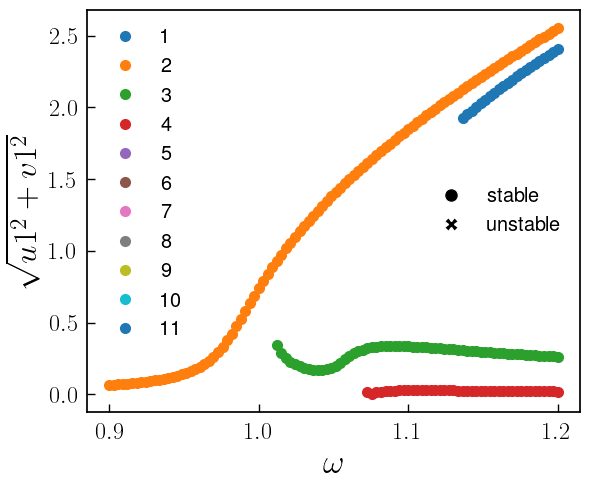

In [199]:
plt = HarmonicBalance.plot_1D_solutions(soln, x="ω", y="sqrt(u1^2 + v1^2)", plot_only=["physical", "stable"]);

In [200]:
# select a solution and evolve from it
s1 = get_single_solution(soln, branch=5, index=75);

sweep = HarmonicBalance.TimeEvolution.ParameterSweep(ω => (s1[ω], 0.95), (0, 1E5))

function t_solve(s)
    problem = HarmonicBalance.TimeEvolution.ODEProblem(averagedEOM, steady_solution=s, timespan=(0,1E5), sweep=sweep)
    time_soln = HarmonicBalance.TimeEvolution.solve(problem,saveat=10);
end

@time time_soln_1 = t_solve(s1);

 93.415295 seconds (302.67 M allocations: 10.952 GiB, 3.74% gc time, 0.06% compilation time)


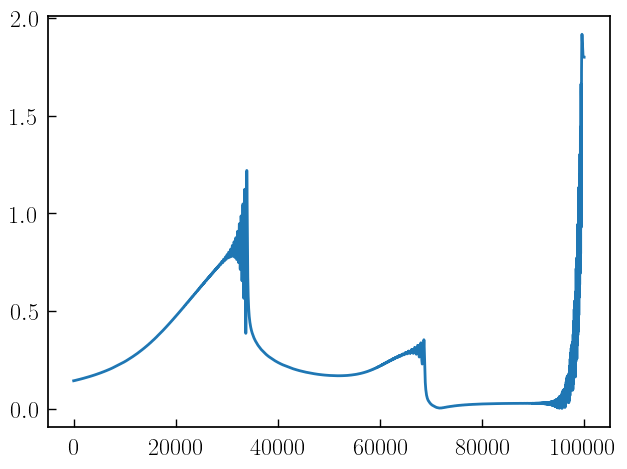

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3c17f6a8e0>

In [201]:
plot_td(s) = HarmonicBalance.plot(s.t, reverse(sqrt.(getindex.(s.u,1).^2 .+ getindex.(s.u,2).^2)))
plot_td(time_soln_1)